# Librairies

In [380]:
"Libraries"
#from helpers import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
import os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, LeakyReLU
from keras.optimizers import Adamax
from keras.regularizers import l2
#import Augmentor 
from keras.utils import np_utils
from keras import backend as K
from theano import ifelse
import random
random.seed(45)

Parameters

In [399]:
window_size = 72 # Size of the window to be fed to the Neural Network.
patch_size = 16 # This is a size of the patch that will be classified.
padding = int((window_size - patch_size)/2) #padding to be added to the image to extract windows

# Import Image

In [382]:
def Import_images():
    """Make a second set of images with rotation of 45 degrees to make the program learn about diagonal road"""
    """ p = Augmentor.Pipeline('training/groundtruth')
    p.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
    #p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
    #p.random_distortion(probability=1,grid_width=4, grid_height=4, magnitude=8)
    #p.crop_random(probability=1, percentage_area=0.5)
    #p.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
    p.flip_left_right(probability=0.5)
    p.flip_top_bottom(probability=0.5)
    p.random_erasing(probability = 0.5, rectangle_area = 0.4)
    p.sample(100)"""
    
    """import all necessary images"""
    # Load the training set
    root_dir = "training/"

    image_dir = root_dir + "images/"
    files = os.listdir(image_dir)
    n = len(files)
    print("Loading " + str(n) + " images")
    imgs = np.asarray([mplimg.imread(image_dir + files[i]) for i in range(n)])

    gt_dir = root_dir + "groundtruth/"
    print("Loading " + str(n) + " images")
    gt_imgs = np.asarray([mplimg.imread(gt_dir + files[i]) for i in range(n)])
    
    
    return imgs,gt_imgs

# Preprocess Image

In [404]:
def Preprocessing(Satellite_images,GT_images,rect_size,patch_size):
    """Preprocess images for Learning"""
    
    """Minibatch"""
    group_size = 1000

    def minibatching(): # Minibatch creation technics.

            # Generate one minibatch
            Satellite_images_group = np.zeros((group_size, rect_size, rect_size, 3)) #j'aurais aussi pu utiliser np.empty
            GT_images_group = np.zeros((group_size, 2))
            for i in range(group_size):
                # Select a random image
                number_image=Satellite_images.shape[0]
                index = np.random.choice(number_image) #https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.random.choice.html

                image_selected=Satellite_images[index]
                image_ground_selected = GT_images[index]
                image_selected_shape = Satellite_images[index].shape
                image_ground_selected_shape = GT_images[index].shape
                
                
                # Sample a random window from the image
                center = np.random.randint(rect_size//2, image_selected_shape[0] - rect_size//2, 2) #Return random integers from the “discrete uniform” distribution of the specified dtype in the “half-open” interval [low, high). #https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.randint.html
                sub_image = image_selected[center[0]-rect_size//2:center[0]+rect_size//2,center[1]-rect_size//2:center[1]+rect_size//2,:]
                # We selected a part of the selected image next to the center that we choose randomly.
                image_window = image_ground_selected[center[0]-patch_size//2:center[0]+patch_size//2,center[1]-patch_size//2:center[1]+patch_size//2]
                # We selected the same part of the image_selected with the random center but this time we take it in the groundthruth image.

                # The label : if the mean of the pixel of the group is superior to the theresold, we thus consider that this is road and the label is one.
                mean = np.array([np.mean(image_window)])
                threshold = 0.35
                label = (mean > threshold) * 1
                # This is the true label that we obtain thanks to the groundthruth image


                # We could have rotate the images rondomly there but we decide to do another way : we create new image wich are rotated

                label = np_utils.to_categorical(label, 2) #road =1 and not_a_road=0 --> Converts a class vector (integers) to binary class matrix.
                Satellite_images_group[i,:] = sub_image
                GT_images_group[i] = label

            return Satellite_images_group, GT_images_group

     #dans dossier on a du code pour baisser le temps de computation et pour fair marcher keras et theanos ensemble
    x,y=minibatching()
    return x,y

# Learn

In [403]:
def Learn(x,y,ws):
        """Process learning on data"""
        in_shape=(ws,ws,3)
    
        def define_model(in_shape):
            CNN_model = Sequential()
            CNN_model.add(Convolution2D(64,5,5,activation='relu',border_mode='same',input_shape=in_shape))
            CNN_model.add(LeakyReLU(alpha=0.1))
            CNN_model.add(MaxPooling2D(pool_size=(2,2),border_mode='same'))
            CNN_model.add(Dropout(0.25))
            
            CNN_model.add(Convolution2D(128,3,3,activation='relu', border_mode='same'))
            CNN_model.add(LeakyReLU(alpha=0.1))
            CNN_model.add(MaxPooling2D(pool_size=(2,2),border_mode='same'))
            CNN_model.add(Dropout(0.25))
            
            CNN_model.add(Convolution2D(256,3,3,activation='relu',border_mode='same'))
            CNN_model.add(LeakyReLU(alpha=0.1))
            CNN_model.add(MaxPooling2D(pool_size=(2,2),border_mode='same'))
            CNN_model.add(Dropout(0.25))
            
            CNN_model.add(Convolution2D(256,3,3,activation='relu',border_mode='same'))
            CNN_model.add(LeakyReLU(alpha=0.1))
            CNN_model.add(MaxPooling2D(pool_size=(2,2),border_mode='same'))
            CNN_model.add(Dropout(0.25))

            CNN_model.add(Flatten())
            CNN_model.add(Dense(100,W_regularizer=l2(1e-6)))
            CNN_model.add(LeakyReLU(alpha=0.1))
            CNN_model.add(Dropout(0.5))
            CNN_model.add(Dense(2,W_regularizer=l2(1e-6),activation='softmax'))
            return CNN_model

        def compile_model(CNN_model):
            CNN_model.compile(loss='categorical_crossentropy',optimizer='Adamax',metrics=['accuracy'])

        print("Creating model")
        model = define_model(in_shape)
        print("Compiling model")
        compile_model(model)
        print("Fitting model")
        model.fit(x, y, batch_size=100, epochs=100, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
        print("Saving weights")
        model.save_weights("models/model1_weights.h5")
        
        return model

# Test Data

In [416]:
def Test(model,ws,ps,padding):
    """Test the model with testing data"""
    def load_test_images():
        test_dir = "test_set_images/"
        files = os.listdir(test_dir)
        n = len(files)
        print("Loading " + str(n) + " images")
        test_img=[]
        for i in range(n):
            cd=test_dir+"test_"+str(i+1)+"/"
            im = mplimg.imread(cd + os.listdir(cd)[0])
            test_img.append(im)
        test_img = np.asarray(test_img)
        return test_img
    
    Test = load_test_images()
    print(Test.shape)
    
    def extract_patches(test_img):
        Test_patches = np.empty((72200,ws,ws,3))
        imgs_id=[]
        
        def img_crop(im, w, h, l):
            list_patches = np.empty((1444,ws,ws,3))
            img_id=[]
            imgwidth = im.shape[0]
            imgheight = im.shape[1]
            for i in range(0,imgheight-2*padding,h):
                for j in range(0,imgwidth-2*padding,w):
                    im_patch = im[j:(j+w+2*padding), i:i+h+2*padding, :]
                    list_patches[int((i/h)*38+(j/w)),...]=im_patch
                    if (l<9):
                        img_id.append("00"+str(l+1)+"_"+str(i)+"_"+str(j))
                    else: img_id.append("0"+str(l+1)+"_"+str(i)+"_"+str(j))
            return np.asarray(list_patches), img_id
        
        def pad_img(img,p):
            image=np.pad(img,((p,p),(p,p),(0,0)),'edge')
            return image
        
        for k in range(test_img.shape[0]):
            image = test_img[k]
            img = pad_img(image,int(padding))
            img_patches, img_id=img_crop(img,ps,ps,k)
            Test_patches[int(k*1444):int((k+1)*1444),...] = img_patches
            imgs_id = np.append(imgs_id,img_id)
        Test_patches = np.asarray(Test_patches)
        print("Test_patches size")
        print(Test_patches.shape)
        print("imgs_id length")
        print(len(imgs_id))
        return Test_patches,imgs_id
            
    Test_patches,img_id = extract_patches(Test)
    Z = model.predict(Test_patches, verbose=1)
    
    Z=(Z[:,0]>Z[:,1])*1
    
    return Z,img_id,Test

In [418]:
def visualize_prediction(predictions, Test):
        for k in range(50):
            gt_values = predictions[k*1444:(k+1)*1444]
            gt_test = np.empty((38,38))
            for i in range(38):
                for j in range(38):
                    gt_test[j,i] = gt_values[i*38+j]
            print(gt_test.shape)
            gt_test=np.asarray(gt_test)
            fig = plt.figure()
            a=fig.add_subplot(1,2,1)
            plt.imshow(gt_test,cmap='gray_r')
            a=fig.add_subplot(1,2,2)
            plt.imshow(Test[k])
            plt.show()
            #input("Press Enter to continue...")

In [438]:
def create_submission(predictions, ids, submission_filename):

    os.remove(submission_filename)
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for k in range(len(ids)):
            f.writelines(ids[k]+','+str(predictions[k])+'\n')
        

# Run

In [405]:
imgs,gt_imgs=Import_images()
print(imgs.shape)

Loading 100 images
Loading 100 images
(100, 400, 400, 3)


In [406]:
x,y=Preprocessing(imgs,gt_imgs,window_size,patch_size)
print(x.shape)
print(y.shape)

(1000, 72, 72, 3)
(1000, 2)


In [407]:
model = Learn(x,y,window_size)

Creating model


/Users/antoine/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu", input_shape=(72, 72, 3..., padding="same")`
  import sys
/Users/antoine/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
  if __name__ == '__main__':
/Users/antoine/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", padding="same")`
  if sys.path[0] == '':
/Users/antoine/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), padding="same")`
  
/Users/antoine/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API

Compiling model
Fitting model
Epoch 1/100
1000/1000 [==============================] - 47s 47ms/step - loss: 0.9283 - acc: 0.7070
Epoch 2/100
1000/1000 [==============================] - 46s 46ms/step - loss: 0.6240 - acc: 0.7610
Epoch 3/100
1000/1000 [==============================] - 47s 47ms/step - loss: 0.5734 - acc: 0.7610
Epoch 4/100
1000/1000 [==============================] - 45s 45ms/step - loss: 0.5630 - acc: 0.7610
Epoch 5/100
1000/1000 [==============================] - 45s 45ms/step - loss: 0.5487 - acc: 0.7610
Epoch 6/100
1000/1000 [==============================] - 45s 45ms/step - loss: 0.5556 - acc: 0.7610
Epoch 7/100
1000/1000 [==============================] - 45s 45ms/step - loss: 0.5571 - acc: 0.7610
Epoch 8/100
1000/1000 [==============================] - 45s 45ms/step - loss: 0.5558 - acc: 0.7610
Epoch 9/100
1000/1000 [==============================] - 47s 47ms/step - loss: 0.5564 - acc: 0.7610
Epoch 10/100
1000/1000 [==============================] - 46s 46ms/ste

1000/1000 [==============================] - 42s 42ms/step - loss: 0.1471 - acc: 0.9320
Epoch 82/100
1000/1000 [==============================] - 42s 42ms/step - loss: 0.1342 - acc: 0.9430
Epoch 83/100
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1199 - acc: 0.9520
Epoch 84/100
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1409 - acc: 0.9390
Epoch 85/100
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1266 - acc: 0.9460
Epoch 86/100
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1271 - acc: 0.9430
Epoch 87/100
1000/1000 [==============================] - 42s 42ms/step - loss: 0.1157 - acc: 0.9540
Epoch 88/100
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1082 - acc: 0.9600
Epoch 89/100
1000/1000 [==============================] - 43s 43ms/step - loss: 0.0915 - acc: 0.9590
Epoch 90/100
1000/1000 [==============================] - 42s 42ms/step - loss: 0.0827 - acc: 0.9700
Epo

In [417]:
pred,img_id, Test_imgs=Test(model,window_size,patch_size,padding)

Loading 50 images
(50, 608, 608, 3)
Test_patches size
(72200, 72, 72, 3)
imgs_id length
72200
72200/72200 [==============================] - 1114s 15ms/step


(38, 38)


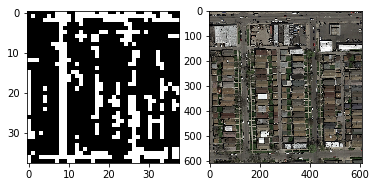

(38, 38)


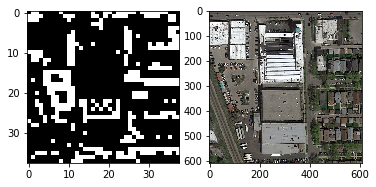

(38, 38)


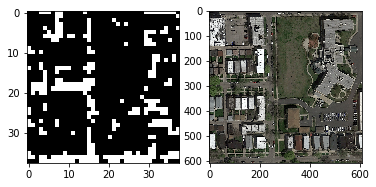

(38, 38)


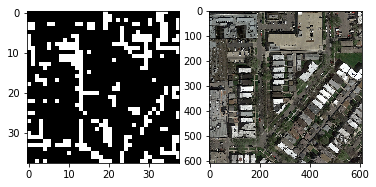

(38, 38)


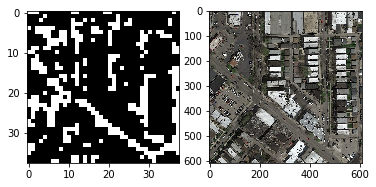

(38, 38)


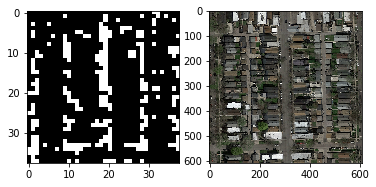

(38, 38)


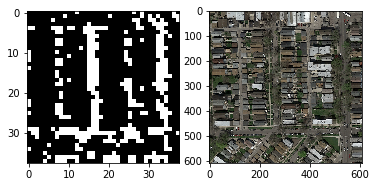

(38, 38)


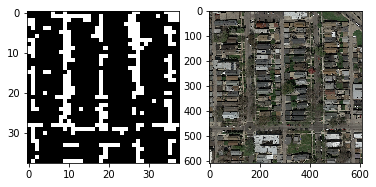

(38, 38)


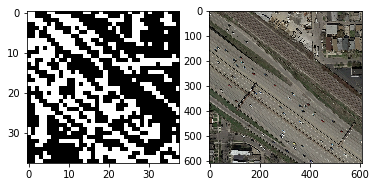

(38, 38)


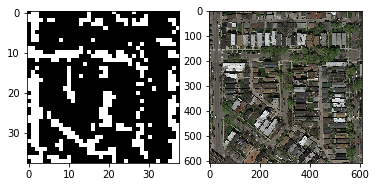

(38, 38)


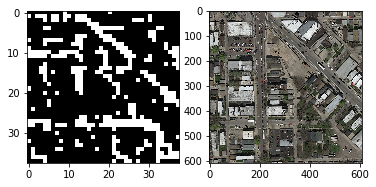

(38, 38)


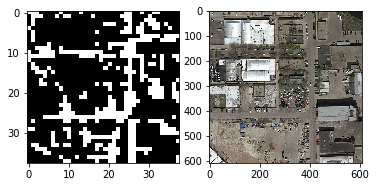

(38, 38)


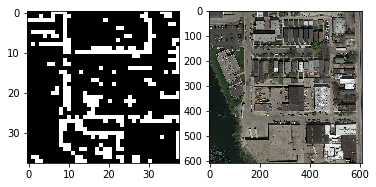

(38, 38)


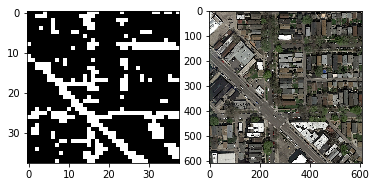

(38, 38)


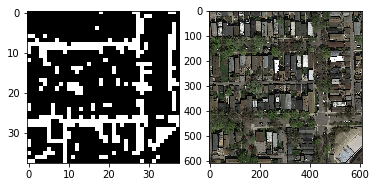

(38, 38)


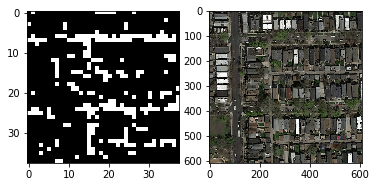

(38, 38)


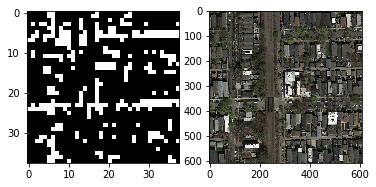

(38, 38)


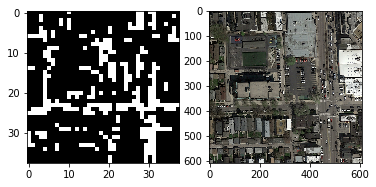

(38, 38)


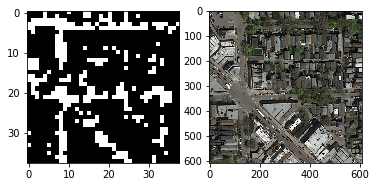

(38, 38)


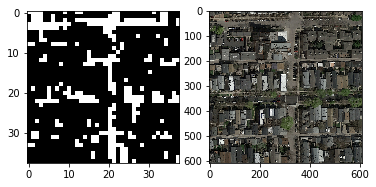

(38, 38)


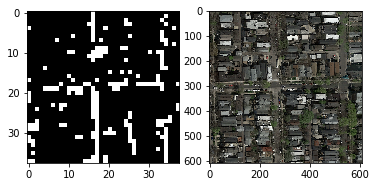

(38, 38)


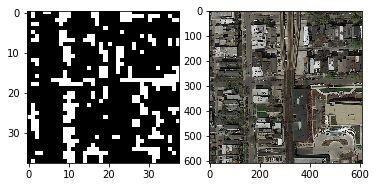

(38, 38)


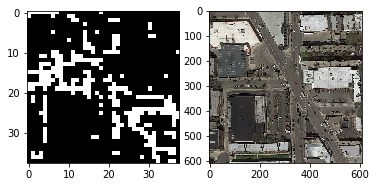

(38, 38)


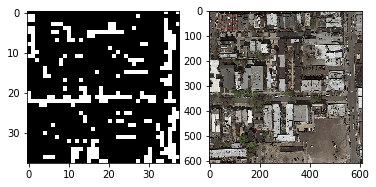

(38, 38)


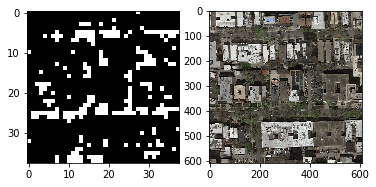

(38, 38)


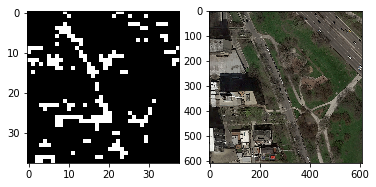

(38, 38)


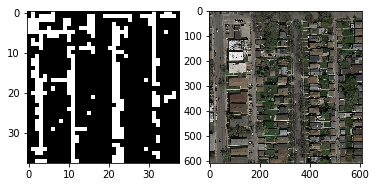

(38, 38)


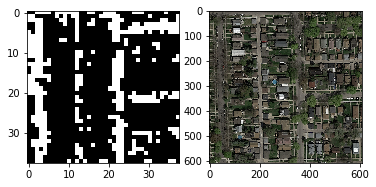

(38, 38)


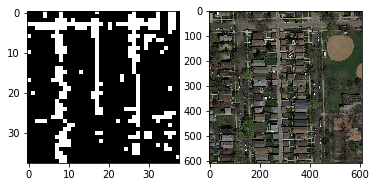

(38, 38)


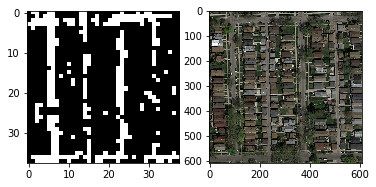

(38, 38)


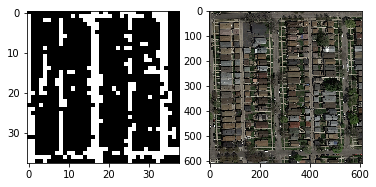

(38, 38)


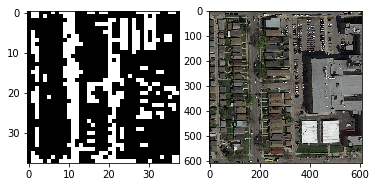

(38, 38)


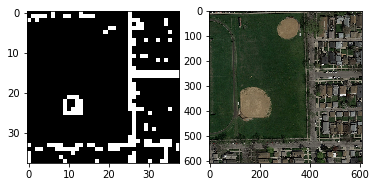

(38, 38)


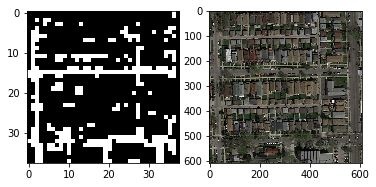

(38, 38)


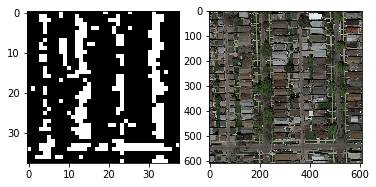

(38, 38)


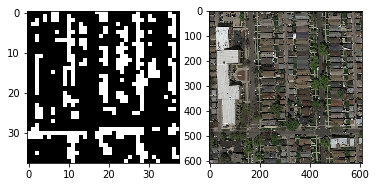

(38, 38)


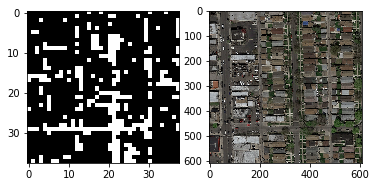

(38, 38)


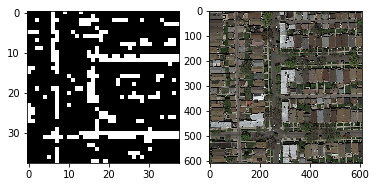

(38, 38)


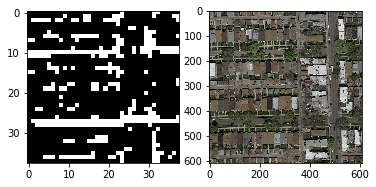

(38, 38)


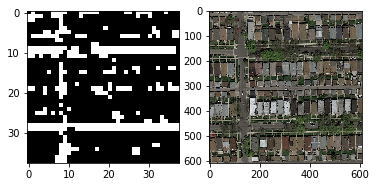

(38, 38)


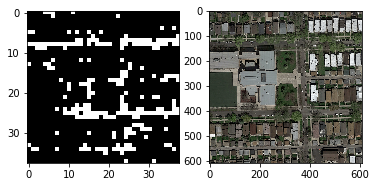

(38, 38)


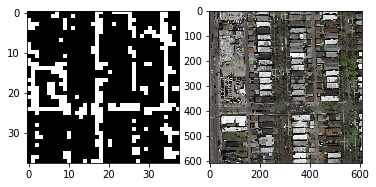

(38, 38)


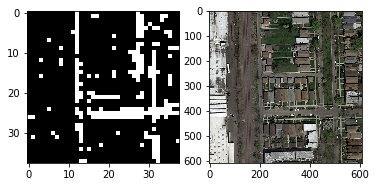

(38, 38)


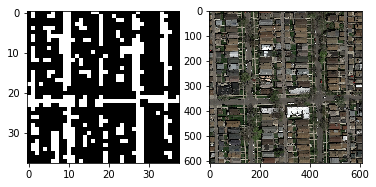

(38, 38)


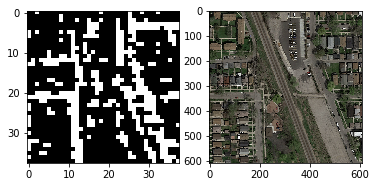

(38, 38)


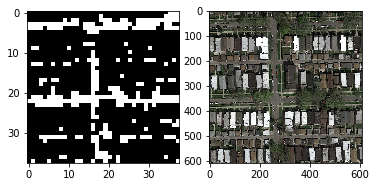

(38, 38)


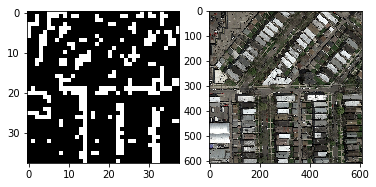

(38, 38)


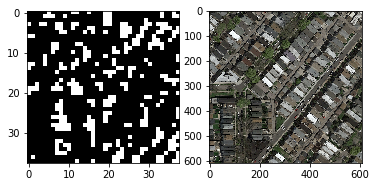

(38, 38)


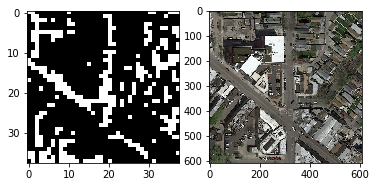

(38, 38)


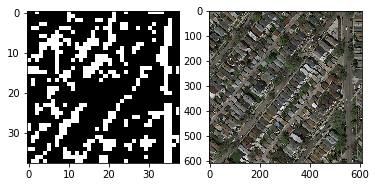

In [419]:
visualize_prediction(pred,Test_imgs)

In [439]:
create_submission(1-pred,img_id,"goodpred.csv")

In [181]:
np.savetxt("good.csv", pred, delimiter=",")

In [420]:
pred[pred==1].shape

(56175,)

In [402]:
pred.shape

(72200,)

In [422]:
(1-pred)[pred==0].shape

(16025,)